In [2]:
import numpy as np
import pandas as pd
import datetime
import re
import requests
import seaborn as sns
from bs4 import BeautifulSoup
import warnings
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from random_forest import *
from optimize_rfr_hyperparams import *
%matplotlib inline

In [33]:
def prepare_data():
    # North Carolina:
    # https://www.newsobserver.com/news/coronavirus/article244546087.html
    # San Francisco:
    # https://data.sfgov.org/COVID-19/COVID-19-Cases-and-Deaths-Summarized-by-ZIP-Code-T/tef6-3vsw/data
    # Montgomery County (MD):
    # https://opendata.maryland.gov/Health-and-Human-Services/MD-COVID-19-Cases-by-ZIP-Code/ntd2-dqpx 
    # and
    # https://www.montgomerycountymd.gov/covid19/data/case-counts.html#zip-code
    nc_df = pd.read_csv('Data/Covid Data/nc_covid_data.csv')
    nc_df.columns = ['Zipcode', 'Case Counts', 'Death Counts']
    display(nc_df)
    sf_df = pd.read_csv('Data/Covid Data/sf_covid_data.csv')
    sf_df.columns = ['Zipcode', 'Case Counts', 'Death Counts']
    display(sf_df)
    mc_df = pd.read_csv('Data/Covid Data/montgomery_county_covid_data.csv')
    mc_df.columns = ['Zipcode', 'Case Counts', 'Death Counts']
    display(mc_df)
    frames = [nc_df, sf_df, mc_df]
    df = pd.concat(frames)
    return df

In [34]:
df = prepare_data()
df['Death Counts'] = df['Death Counts'].fillna(0)
df['Case Counts'] = df['Case Counts'].fillna(0)

,Zipcode,Case Counts,Death Counts
0,28777,1310,14.0
1,28725,17,NaN
2,28719,844,9.0
3,28668,22,NaN
4,28667,39,NaN
...,...,...,...
744,27950,35,NaN
745,27936,21,1.0
746,27531,9,NaN
747,27503,136,NaN


,Zipcode,Case Counts,Death Counts
0,94102,5956.0,55.0
1,94103,6057.0,31.0
2,94104,NaN,NaN
3,94105,1813.0,NaN
4,94107,4617.0,11.0
5,94108,1424.0,20.0
6,94109,7499.0,69.0
7,94110,11915.0,74.0
8,94111,525.0,NaN
9,94112,14499.0,110.0


,Zipcode,Case Counts,Death Counts
0,20906,13708,193
1,20904,11248,164
2,20902,10826,128
3,20850,7811,116
4,20852,6679,105
5,20910,6405,91
6,20877,7869,87
7,20854,6135,84
8,20874,11432,74
9,20817,4521,63


In [5]:
def scrape(z):
        z = str(z)
        source = requests.get('https://censusreporter.org/profiles/86000US{zip}-{zip}/'.format(zip=z)).text
        soup = BeautifulSoup(source, 'lxml')
        s = soup.findAll('script',type="text/javascript")[1]
        return str(s)

def parse(param, sp):
    param = '"'+param+'", '
    try:
        var = float(re.findall(param+'"values": {"this":\s*([+-]?[0-9]+\.[0-9]+)',sp)[0])
    except:
        var = 0

    return var

def getSocioDem(zipcodes):
    df = pd.DataFrame(columns = [ 'Zipcode', 'Population', 'Median age', 'Under 18(%)', '18 to 64(%)', '65 and over(%)', 'Male(%)', 'Female(%)', 'White(%)', "Black(%)", "Native(%)", "Asian(%)", "Islander(%)", "Two plus(%)", "Hispanic(%)", "Per capita income (USD)", "Median household income (USD)", "Below poverty line(%)",
                                'Mean travel time to work (Minutes)', 'Drove Alone (%)', 'Carpooled (%)', 'Public Transit (%)', 'Bicycle (%)', 'Walked (%)', 'Other (%)', 'Worked at home (%)', 'Number of households', 'Persons per household', 'Married (%)', 'Single (%)',
                                'Number of housing units', 'Occupied housing (%)', 'Vacant housing (%)', 'Owner Occupied (%)', 'Renter Occupied (%)', 'Median housing value',
                                'Moved Since Prev Year(%)', 'Same House Prev Year(%)', 'No Degree(%)', 'High School(%)', 'Some College(%)', "Bachelor's(%)", "Post-grad(%)", 'Foriegn Born Population(%)', 'Europe(%)', 'Asia(%)', 'Africa(%)', 'Oceania(%)', 'Latin America(%)', 'North America(%)'],
                                index = list(range(0,len(zipcodes))))

    i = 0
    for zip in zipcodes:
        try:
            s = scrape(zip)
        except:
            continue
        var = '"full_geoid": "86000US{z}", "total_population":'.format(z=str(zip))
        population = int(re.findall(var+'\s*([+-]?[0-9]+)',s)[0])
        
        median_age = parse("Median age",s)
        percent_under18 = parse("Under 18",s)
        percent_18to64 = parse("18 to 64",s)
        percent_65andOver = parse("65 and over",s)

        percent_male = parse("Male",s)
        percent_female = parse("Female",s)

        percent_white = parse("White",s)
        percent_black = parse("Black",s)
        percent_native = parse("Native",s)
        percent_asian = parse("Asian",s)
        percent_islander = parse("Islander",s)
        pecent_two_plus = parse("Two\+",s)
        percent_hispanic = parse("Hispanic",s)

        per_capita = parse("Per capita income", s)
        median_household_income = parse("Median household income",s)

        percent_below_poverty = parse("Persons below poverty line",s)

        mean_travel_time = parse("Mean travel time to work",s)
        drove_alone = parse("Drove alone",s)
        carpooled = parse("Carpooled",s)
        public_transit = parse("Public transit",s)
        bicycle = parse("Bicycle",s)
        walked = parse("Walked",s)
        other = parse("Other",s)
        worked_at_home = parse("Worked at home",s)

        number_of_households = parse("Number of households",s)
        persons_per_household = parse("Persons per household",s)

        married = parse("Married",s)
        single = parse("Single",s)
        
        number_of_housing_units = parse("Number of housing units",s)
        occupied_housing_units = parse("Occupied",s)
        vacant_housing_units = parse("Vacant",s)
        owner_housing_units = parse("Owner occupied",s)
        renter_housing_units = parse("Renter occupied",s)

        median_value_owner_occupied = parse("Median value of owner-occupied housing units",s)

        moved_since_previous_year = parse("Moved since previous year",s)
        same_house_year_ago = parse("Same house year ago",s)

        no_degree = parse("No degree",s)
        high_school = parse("High school",s)
        some_college = parse("Some college",s)
        bachelors = parse("Bachelor's",s)
        post_grad = parse("Post-grad",s)

        foriegn_born_pop = parse("Foreign-born population",s)
        europe = parse('Europe',s)
        asia = parse('Asia',s)
        africa = parse('Africa',s)
        oceania = parse('Oceania',s)
        latin_america = parse('Latin America',s)
        north_america = parse('North America',s)

        df.iloc[i] = [zip, population, median_age, percent_under18, percent_18to64, percent_65andOver, percent_male, percent_female, percent_white, percent_black, percent_native, percent_asian, percent_islander, pecent_two_plus, percent_hispanic, per_capita, median_household_income, percent_below_poverty, mean_travel_time,
        drove_alone, carpooled, public_transit, bicycle, walked, other, worked_at_home, number_of_households, persons_per_household, married, single, number_of_housing_units, occupied_housing_units, vacant_housing_units, owner_housing_units, renter_housing_units,
        median_value_owner_occupied, moved_since_previous_year, same_house_year_ago, no_degree, high_school, some_college, bachelors, post_grad, foriegn_born_pop, europe, asia, africa, oceania, latin_america, north_america]

        i+=1
    return df

In [6]:
#scrape social demographic data 
zipcodes = df.Zipcode.tolist()
socio_df = getSocioDem(zipcodes)

In [7]:
socio_df['Zipcode'].isnull().sum()
socio_df.iloc[:-2]

,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Some College(%),Bachelor's(%),Post-grad(%),Foriegn Born Population(%),Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%)
0,28777,10546,43.9,14.74,67.02,18.24,60.8,39.2,82.52,5.77,...,34.09,13.32,5.54,5.95,11.31,8.76,3.82,2.55,58.12,15.45
1,28725,23,32.4,43.48,56.52,0,60.87,39.13,78.26,0,...,0,61.54,38.46,0,0,0,0,0,0,0
2,28719,7404,36.2,25.63,59.09,15.28,49.55,50.45,13.28,1.03,...,32.96,9.52,4.2,2.32,0,43.02,0,0,56.98,0
3,28668,341,60.3,13.2,53.96,32.84,51.61,48.39,98.53,0.59,...,24.82,43.62,15.25,19.65,83.58,0,0,0,4.48,11.94
4,28667,363,34.6,29.75,58.95,11.29,52.62,47.38,81.54,0,...,14.42,4.65,3.72,3.58,0,0,0,0,100.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,21771,31366,41.1,24.84,61.14,14.02,49.84,50.16,86.76,2.88,...,27.03,25.2,17.94,5.25,12.14,30.24,2.37,0.55,53.55,1.15
814,20783,45550,31.1,29.51,62.06,8.43,53.45,46.55,5.29,24.58,...,17.34,12.5,7.05,55.99,0.96,4.89,16.57,0,77.49,0.09
815,20862,359,63.5,5.01,46.52,48.47,47.08,52.92,91.09,0,...,1.58,29.11,16.77,5.29,0,0,52.63,0,47.37,0
816,20868,539,39.0,26.35,61.97,11.69,48.61,51.39,27.46,4.45,...,23.5,33.88,13.11,32.28,0,16.67,0,0,83.33,0


In [35]:
merge_df = pd.merge(socio_df, df, how='inner', on='Zipcode')
zero_rows = merge_df[merge_df['Population'] == 0].index.tolist()
merge_df = merge_df.drop(zero_rows)
merge_df['Death Counts(Per 1000)'] = (merge_df['Death Counts'] / merge_df['Population']) * 1000
merge_df['Case Counts(Per 1000)'] = (merge_df['Case Counts'] / merge_df['Population']) * 1000
merge_df

,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Case Counts,Death Counts,Death Counts(Per 1000),Case Counts(Per 1000)
0,28777,10546,43.9,14.74,67.02,18.24,60.8,39.2,82.52,5.77,...,11.31,8.76,3.82,2.55,58.12,15.45,1310.0,14.0,1.327518,124.217713
1,28725,23,32.4,43.48,56.52,0,60.87,39.13,78.26,0,...,0,0,0,0,0,0,17.0,0.0,0.0,739.130435
2,28719,7404,36.2,25.63,59.09,15.28,49.55,50.45,13.28,1.03,...,0,43.02,0,0,56.98,0,844.0,9.0,1.215559,113.992437
3,28668,341,60.3,13.2,53.96,32.84,51.61,48.39,98.53,0.59,...,83.58,0,0,0,4.48,11.94,22.0,0.0,0.0,64.516129
4,28667,363,34.6,29.75,58.95,11.29,52.62,47.38,81.54,0,...,0,0,0,0,100.0,0,39.0,0.0,0.0,107.438017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,20862,359,63.5,5.01,46.52,48.47,47.08,52.92,91.09,0,...,0,0,52.63,0,47.37,0,48.0,2.0,5.571031,133.704735
816,20868,539,39.0,26.35,61.97,11.69,48.61,51.39,27.46,4.45,...,0,16.67,0,0,83.33,0,143.0,2.0,3.710575,265.306122
817,20705,28348,36.4,24.54,59.8,15.66,47.2,52.8,18.32,37.97,...,3.41,26.8,21.36,0,48.24,0.18,5787.0,1.0,0.035276,204.141386
818,20707,32184,38.4,23.23,63.28,13.5,46.5,53.5,22.82,45.15,...,4.07,26.14,28.99,0,39.91,0.88,6958.0,1.0,0.031071,216.194382


In [3]:
def prepare_data():
    # Newyork:
    # https://raw.githubusercontent.com/nychealth/coronavirus-data/master/totals/data-by-modzcta.csv
    # City of San Antonio:
    # https://cosacovid-cosagis.hub.arcgis.com/datasets/CoSAGIS::covid19-deaths-by-zip-code/about
    # Wisconsin:
    # https://data.dhsgis.wi.gov/datasets/wi-dhs::covid-19-data-by-zip-code-tabulation-area-v2/about
    il_df = pd.read_csv('COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv')
    ny_df = ny_df[['ZIP Code', 'COVID_CASE_COUNT', 'COVID_DEATH_COUNT']]
    ny_df.columns = ['Zipcode', 'Case Counts', 'Death Counts']
    display(ny_df)
    sa_df = pd.read_csv('Data/Covid Data/san-antonio-covid19-cases-and-deaths.csv')
    sa_df = sa_df[['ZIP_CODE', 'Positive','Deaths']]
    sa_df.columns = ['Zipcode', 'Case Counts', 'Death Counts']
    display(sa_df)
    wi_df = pd.read_csv('Data/Covid Data/wisconsin-covid19-cases-and-deaths.csv')
    wi_df = wi_df[['GEOID', 'POS_CUM_CP', 'DTH_CUM_CP']]
    wi_df.columns = ['Zipcode', 'Case Counts', 'Death Counts']
    display(wi_df)
    frames = [ny_df, sa_df, wi_df]
    df = pd.concat(frames)
    return df

In [36]:
# drop data rows that have 0 mean household income
merge_df = merge_df.drop(merge_df[merge_df['Median household income (USD)'] == 0].index.tolist())
merge_df['Death Counts(Per 1000)'] = (merge_df['Death Counts'] / merge_df['Population']) * 1000
merge_df['Case Counts(Per 1000)'] = (merge_df['Case Counts'] / merge_df['Population']) * 1000
merge_df

,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Case Counts,Death Counts,Death Counts(Per 1000),Case Counts(Per 1000)
0,28777,10546,43.9,14.74,67.02,18.24,60.8,39.2,82.52,5.77,...,11.31,8.76,3.82,2.55,58.12,15.45,1310.0,14.0,1.327518,124.217713
2,28719,7404,36.2,25.63,59.09,15.28,49.55,50.45,13.28,1.03,...,0,43.02,0,0,56.98,0,844.0,9.0,1.215559,113.992437
4,28667,363,34.6,29.75,58.95,11.29,52.62,47.38,81.54,0,...,0,0,0,0,100.0,0,39.0,0.0,0.0,107.438017
5,28658,27818,41.7,21.38,60.04,18.57,48.45,51.55,71.64,8.21,...,6.78,9.57,0.56,0,80.85,2.24,2808.0,37.0,1.330074,100.941836
6,28646,393,52.8,16.03,49.62,34.35,54.71,45.29,92.88,0,...,92.86,0,0,0,0,7.14,59.0,1.0,2.544529,150.127226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,20783,45550,31.1,29.51,62.06,8.43,53.45,46.55,5.29,24.58,...,0.96,4.89,16.57,0,77.49,0.09,8505.0,2.0,0.043908,186.717892
815,20862,359,63.5,5.01,46.52,48.47,47.08,52.92,91.09,0,...,0,0,52.63,0,47.37,0,48.0,2.0,5.571031,133.704735
817,20705,28348,36.4,24.54,59.8,15.66,47.2,52.8,18.32,37.97,...,3.41,26.8,21.36,0,48.24,0.18,5787.0,1.0,0.035276,204.141386
818,20707,32184,38.4,23.23,63.28,13.5,46.5,53.5,22.82,45.15,...,4.07,26.14,28.99,0,39.91,0.88,6958.0,1.0,0.031071,216.194382


In [39]:
print(merge_df.columns)
merge_df = merge_df.drop(merge_df[merge_df['Median household income (USD)'] == 0].index.tolist())
merge_df[merge_df['Median household income (USD)'] == 0]

Index(['Zipcode', 'Population', 'Median age', 'Under 18(%)', '18 to 64(%)',
       '65 and over(%)', 'Male(%)', 'Female(%)', 'White(%)', 'Black(%)',
       'Native(%)', 'Asian(%)', 'Islander(%)', 'Two plus(%)', 'Hispanic(%)',
       'Per capita income (USD)', 'Median household income (USD)',
       'Below poverty line(%)', 'Mean travel time to work (Minutes)',
       'Drove Alone (%)', 'Carpooled (%)', 'Public Transit (%)', 'Bicycle (%)',
       'Walked (%)', 'Other (%)', 'Worked at home (%)', 'Number of households',
       'Persons per household', 'Married (%)', 'Single (%)',
       'Number of housing units', 'Occupied housing (%)', 'Vacant housing (%)',
       'Owner Occupied (%)', 'Renter Occupied (%)', 'Median housing value',
       'Moved Since Prev Year(%)', 'Same House Prev Year(%)', 'No Degree(%)',
       'High School(%)', 'Some College(%)', 'Bachelor's(%)', 'Post-grad(%)',
       'Foriegn Born Population(%)', 'Europe(%)', 'Asia(%)', 'Africa(%)',
       'Oceania(%)', 'Latin Ame

,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Case Counts,Death Counts,Death Counts(Per 1000),Case Counts(Per 1000)


In [41]:
display(merge_df)
merge_df.to_csv('socio-demographic-and-death-counts.csv',index=False)
merge_df = pd.read_csv('socio-demographic-and-death-counts.csv')
merge_df

,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Case Counts,Death Counts,Death Counts(Per 1000),Case Counts(Per 1000)
0,28777,10546,43.9,14.74,67.02,18.24,60.8,39.2,82.52,5.77,...,11.31,8.76,3.82,2.55,58.12,15.45,1310.0,14.0,1.327518,124.217713
2,28719,7404,36.2,25.63,59.09,15.28,49.55,50.45,13.28,1.03,...,0,43.02,0,0,56.98,0,844.0,9.0,1.215559,113.992437
4,28667,363,34.6,29.75,58.95,11.29,52.62,47.38,81.54,0,...,0,0,0,0,100.0,0,39.0,0.0,0.0,107.438017
5,28658,27818,41.7,21.38,60.04,18.57,48.45,51.55,71.64,8.21,...,6.78,9.57,0.56,0,80.85,2.24,2808.0,37.0,1.330074,100.941836
6,28646,393,52.8,16.03,49.62,34.35,54.71,45.29,92.88,0,...,92.86,0,0,0,0,7.14,59.0,1.0,2.544529,150.127226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,20783,45550,31.1,29.51,62.06,8.43,53.45,46.55,5.29,24.58,...,0.96,4.89,16.57,0,77.49,0.09,8505.0,2.0,0.043908,186.717892
815,20862,359,63.5,5.01,46.52,48.47,47.08,52.92,91.09,0,...,0,0,52.63,0,47.37,0,48.0,2.0,5.571031,133.704735
817,20705,28348,36.4,24.54,59.8,15.66,47.2,52.8,18.32,37.97,...,3.41,26.8,21.36,0,48.24,0.18,5787.0,1.0,0.035276,204.141386
818,20707,32184,38.4,23.23,63.28,13.5,46.5,53.5,22.82,45.15,...,4.07,26.14,28.99,0,39.91,0.88,6958.0,1.0,0.031071,216.194382


,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Case Counts,Death Counts,Death Counts(Per 1000),Case Counts(Per 1000)
0,28777,10546,43.9,14.74,67.02,18.24,60.80,39.20,82.52,5.77,...,11.31,8.76,3.82,2.55,58.12,15.45,1310.0,14.0,1.327518,124.217713
1,28719,7404,36.2,25.63,59.09,15.28,49.55,50.45,13.28,1.03,...,0.00,43.02,0.00,0.00,56.98,0.00,844.0,9.0,1.215559,113.992437
2,28667,363,34.6,29.75,58.95,11.29,52.62,47.38,81.54,0.00,...,0.00,0.00,0.00,0.00,100.00,0.00,39.0,0.0,0.000000,107.438017
3,28658,27818,41.7,21.38,60.04,18.57,48.45,51.55,71.64,8.21,...,6.78,9.57,0.56,0.00,80.85,2.24,2808.0,37.0,1.330074,100.941836
4,28646,393,52.8,16.03,49.62,34.35,54.71,45.29,92.88,0.00,...,92.86,0.00,0.00,0.00,0.00,7.14,59.0,1.0,2.544529,150.127226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,20783,45550,31.1,29.51,62.06,8.43,53.45,46.55,5.29,24.58,...,0.96,4.89,16.57,0.00,77.49,0.09,8505.0,2.0,0.043908,186.717892
797,20862,359,63.5,5.01,46.52,48.47,47.08,52.92,91.09,0.00,...,0.00,0.00,52.63,0.00,47.37,0.00,48.0,2.0,5.571031,133.704735
798,20705,28348,36.4,24.54,59.80,15.66,47.20,52.80,18.32,37.97,...,3.41,26.80,21.36,0.00,48.24,0.18,5787.0,1.0,0.035276,204.141386
799,20707,32184,38.4,23.23,63.28,13.50,46.50,53.50,22.82,45.15,...,4.07,26.14,28.99,0.00,39.91,0.88,6958.0,1.0,0.031071,216.194382


In [42]:
df = pd.read_csv('socio-demographic-and-death-counts.csv')
death = df['Death Counts']
case = df['Case Counts']
death1000 = df['Death Counts(Per 1000)']
case1000 = df['Case Counts(Per 1000)']
df = df.drop(['Death Counts', 'Case Counts','Death Counts(Per 1000)','Case Counts(Per 1000)'],axis=1)
df['Death Counts'] = death
df['Death Counts(Per 1000)'] = death1000
df['Case Counts'] = case
df['Case Counts(Per 1000)'] = case1000
df.to_csv('socio-demographic-and-death-counts.csv',index=False)

In [43]:
df.isnull().sum().sum()

0

In [3]:
mergedSocCovid = pd.read_csv("socio-demographic-and-death-counts(combined).csv")

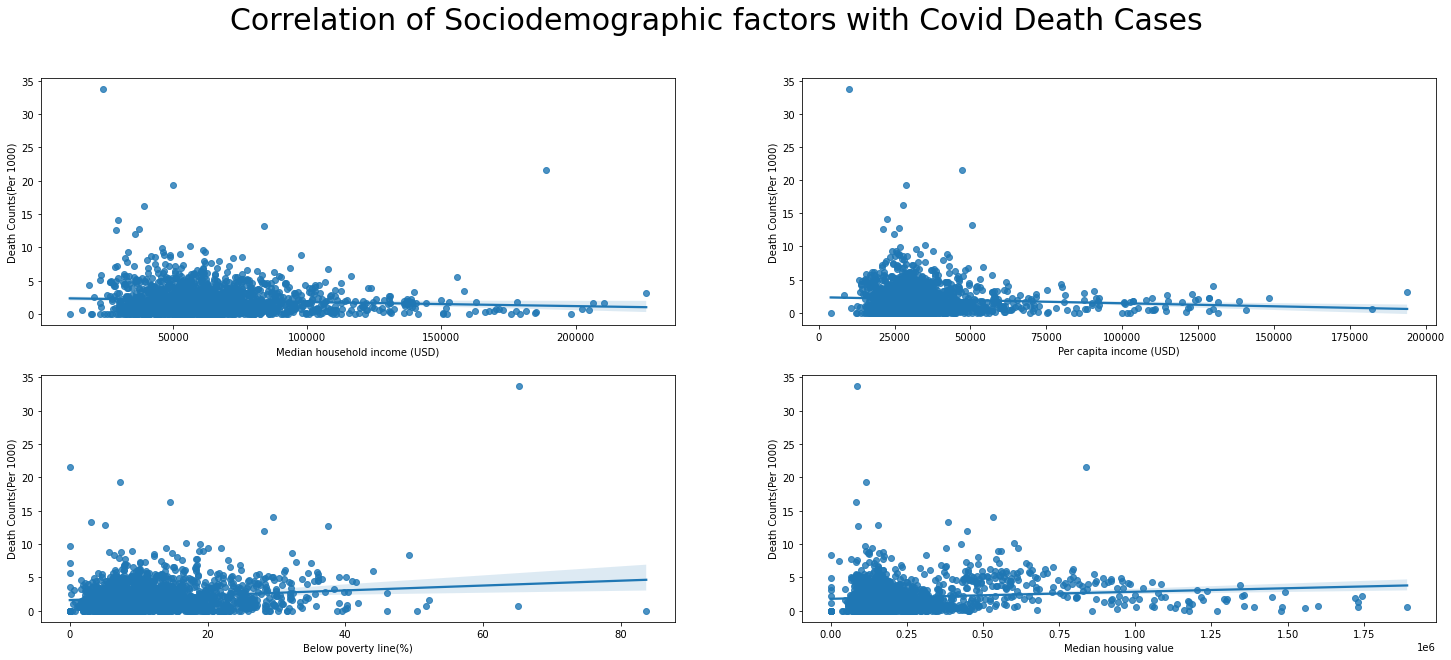

In [4]:
def scatterPlot(mergedSocCovid):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(25,10))
    fig.suptitle('Correlation of Sociodemographic factors with Covid Death Cases',fontsize=30)

    sns.regplot(ax=ax1, data=mergedSocCovid, x="Median household income (USD)", y="Death Counts(Per 1000)")
    sns.regplot(ax=ax2, data=mergedSocCovid, x="Per capita income (USD)", y="Death Counts(Per 1000)")
    sns.regplot(ax=ax3, data=mergedSocCovid, x="Below poverty line(%)", y="Death Counts(Per 1000)")
    sns.regplot(ax=ax4, data=mergedSocCovid, x="Median housing value", y="Death Counts(Per 1000)")
scatterPlot(mergedSocCovid)

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
mergedSocCovid

,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Death Counts,Death Counts(Per 1000),Case Counts,Case Counts(Per 1000)
0,10001,25026,36.1,10.98,76.38,12.64,49.01,50.99,54.51,6.14,...,19.08,49.55,2.25,3.52,21.46,4.13,57,2.277631,7745,309.478143
1,10002,74363,44.8,13.09,63.18,23.74,49.29,50.71,22.16,7.77,...,5.55,79.01,0.61,1.27,12.85,0.70,412,5.540390,19171,257.802940
2,10003,54671,31.9,7.18,80.16,12.66,48.78,51.22,67.98,5.01,...,30.11,41.21,1.84,6.09,15.72,5.03,84,1.536464,13634,249.382671
3,10004,3310,38.4,7.37,84.23,8.40,47.34,52.66,66.89,4.50,...,27.89,53.26,2.97,7.42,2.08,6.38,2,0.604230,973,293.957704
4,10005,8664,30.4,10.20,88.73,1.06,47.68,52.32,70.16,2.01,...,36.36,41.91,0.72,9.01,8.49,3.52,1,0.115420,2323,268.120960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,60623,77732,32.9,26.57,61.25,12.18,49.35,50.65,3.85,28.58,...,0.39,0.79,0.22,0.10,98.32,0.17,307,3.949467,19109,245.831832
1848,60629,107930,31.3,28.86,59.73,11.41,48.81,51.19,7.08,18.07,...,3.92,2.31,0.41,0.05,93.20,0.10,318,2.946354,27819,257.750394
1849,60620,68761,39.4,23.56,58.46,17.98,45.13,54.87,1.16,94.82,...,0.64,14.33,13.82,0.06,71.15,0.00,248,3.606696,11979,174.212126
1850,60637,46621,31.0,22.88,64.79,12.34,43.82,56.18,13.84,74.70,...,17.46,47.58,16.12,2.60,14.00,2.24,87,1.866112,8689,186.375239


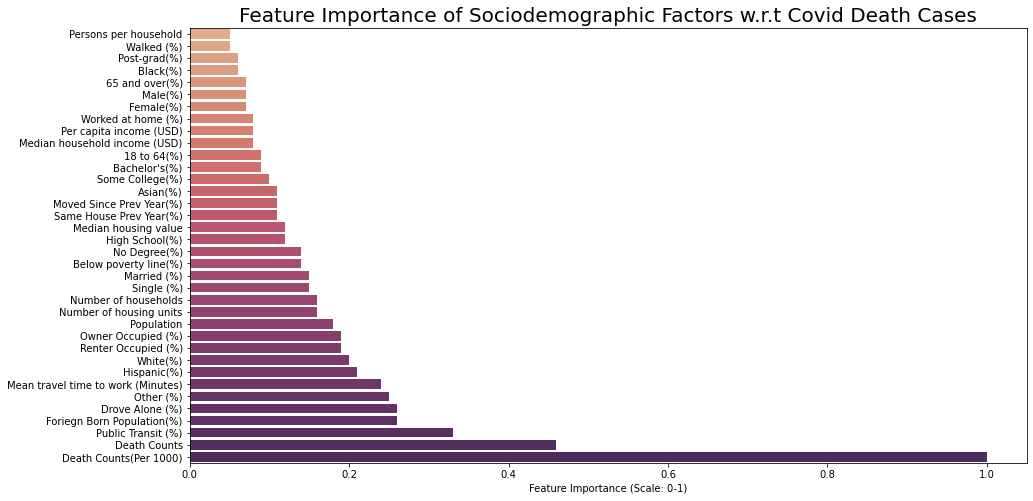

In [15]:
def featureImportance(mergedSocCovid):
    cormat = mergedSocCovid.corr().abs()
    cormat = cormat[cormat>0.05]
    feature_importance = round(cormat,2).dropna(subset=['Death Counts(Per 1000)'])['Death Counts(Per 1000)'].to_frame().reset_index()
    feature_importance = feature_importance[:-2]
    feature_importance = feature_importance.sort_values(by='Death Counts(Per 1000)')
    plt.figure(figsize=(15,8))
    ax = sns.barplot(data=feature_importance, y='index', x='Death Counts(Per 1000)', palette='flare')
    plt.xlabel('Feature Importance (Scale: 0-1)')
    plt.ylabel('')
    plt.title('Feature Importance of Sociodemographic Factors w.r.t Covid Death Cases',fontsize=20)
featureImportance(mergedSocCovid)